In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
RMSE = lambda y_true,y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
FOLDER = 'gsc'
FEATURE_AGGREGATION = 'subtr'
TRAIN_TEST_PARTITION = 'unseen'
LAMBDA = 10

"NN hyperparams"
HIDDEN1_SIZE = 32
HIDDEN2_SIZE = 8
DO_VAL = 0.7

In [3]:
# %store -r FEATURE_AGGREGATION
# %store -r TRAIN_TEST_PARTITION
# %store -r FOLDER
# %store -r LAMBDA

# # NN hyperparams
# %store -r HIDDEN1_SIZE
# %store -r HIDDEN2_SIZE
# %store -r DO_VAL

In [4]:
results = {
    'lambda': LAMBDA,
    'data_partition': TRAIN_TEST_PARTITION,
    'features': FOLDER,
    'nn_hidden_1_size': HIDDEN1_SIZE,
    'nn_hidden_2_size': HIDDEN2_SIZE,
    'feature_agg': FEATURE_AGGREGATION,
    'dropout_val': DO_VAL
}

In [5]:
params_name = "-".join([str(x) for x in results.values()])

In [6]:
if FOLDER == 'gsc':
    features_path = './GSC-Dataset/GSC-Features-Data/GSC-Features.csv'
else:
    features_path = './HumanObserved-Dataset/HumanObserved-Features-Data/HumanObserved-Features-Data.csv'

In [7]:
idx_tr = pd.read_csv(f"./data/{FOLDER}/{TRAIN_TEST_PARTITION}_train.csv", index_col=0)
idx_v = pd.read_csv(f"./data/{FOLDER}/{TRAIN_TEST_PARTITION}_valid.csv", index_col=0)
idx_test = pd.read_csv(f"./data/{FOLDER}/test.csv", index_col=0)
features = pd.read_csv(features_path)

In [8]:
def generate_subtr(idx, features):
    A = idx.merge(features, left_on='img_id_A', right_on='img_id', how='left').filter(regex='f[0-9]+')
    B = idx.merge(features, left_on='img_id_B', right_on='img_id', how='left').filter(regex='f[0-9]+')
    res = (A - B).abs()
    return res.values

In [9]:
idx_tr = idx_tr.sample(frac=0.2, weights=10*idx_tr.target+1)

In [10]:
Xtr = generate_subtr(idx_tr, features)
ytr = idx_tr.target.values

Xv = generate_subtr(idx_v, features)
yv = idx_v.target.values

Xts = generate_subtr(idx_test, features) if FOLDER == 'human' else Xv
yts = idx_test.target.values if FOLDER == 'human' else yv

### Linear regression

In [11]:
import linear_model as lm
from sklearn.pipeline import Pipeline

In [12]:
use_RBFs = FOLDER == 'gsc' and FEATURE_AGGREGATION == 'concat'#only using RBFs when having lots of features

In [13]:
if use_RBFs:
    linear = Pipeline([
        ('rbf', lm.RBF_transformer(25, cache=True)),
        ('lin_r', lm.LinRegression(n_features=16, metric='accuracy', lambda_=LAMBDA))
    ])

    logistic = Pipeline([
        ('rbf', lm.RBF_transformer(25, cache=True)),
        ('log_r', lm.LogRegression(n_features=16, metric='accuracy', lambda_=LAMBDA))
    ])
else:
    linear = Pipeline([
        ('lin_r', lm.LinRegression(n_features=Xtr.shape[1], metric='accuracy', lambda_=LAMBDA))
    ])
    logistic = Pipeline([
        ('log_r', lm.LogRegression(n_features=Xtr.shape[1], metric='accuracy', lambda_=LAMBDA))
    ])

In [14]:
sampler = lm.Subsampler(1, y_oh=False, normalize=not use_RBFs, neg_weight=1)

In [15]:
sampler.fit(Xtr, ytr);

In [16]:
Xv_ss, yv_ss = sampler.transform(Xv, yv, sample=True)

In [17]:
from sklearn.linear_model import LogisticRegression

In [18]:
linear.fit(Xtr, ytr,
           lin_r__batch_generator = sampler,
           lin_r__n_epochs=500 if FOLDER == 'human' else 100,
           lin_r__valid_set=(Xv_ss, yv_ss));

HBox(children=(IntProgress(value=0, max=99), HTML(value='')))

In [19]:
logistic.fit(Xtr, ytr,
           	 log_r__batch_generator = sampler,
           	 log_r__n_epochs=500 if FOLDER == 'human' else 100,
           	 log_r__valid_set=(Xv_ss, yv_ss));

HBox(children=(IntProgress(value=0, max=99), HTML(value='')))

In [20]:
results['linear_accuracy_ss'] = linear.score(Xv_ss, yv_ss)
results['linear_accuracy_full'] = linear.score(Xv,yv)
results['linear_accuracy_test'] = linear.score(Xts,yts)

In [21]:
results['logistic_accuracy_ss'] = logistic.score(Xv_ss, yv_ss)
results['logistic_accuracy_full'] = logistic.score(Xv, yv)
results['logistic_accuracy_test'] = logistic.score(Xts, yts)

In [22]:
lin_r = [x[1] for x in linear.steps if x[0] == 'lin_r'].pop()
log_r = [x[1] for x in logistic.steps if x[0] == 'log_r'].pop()

In [23]:
fh = lin_r.fit_hist_
plt.title('Linear regression')
plt.plot([x[0] for x in fh], [x[1] for x in fh], c='g', label='train_score')
plt.plot([x[0] for x in fh], [x[2] for x in fh], c='m', label='val_score')
plt.legend()
plt.savefig(f"./results/{FEATURE_AGGREGATION}/lin_{params_name}.png")

In [24]:
fh = log_r.fit_hist_
plt.title('Logistic regression')
plt.plot([x[0] for x in fh], [x[1] for x in fh], c='g', label='train_score')
plt.plot([x[0] for x in fh], [x[2] for x in fh], c='m', label='val_score')
plt.legend()
plt.savefig(f"./results/{FEATURE_AGGREGATION}/log_{params_name}.png")

In [25]:
lin_r.metric = 'RMSE'
log_r.metric = 'RMSE'

In [26]:
results['linear_RMSE_ss'] = linear.score(Xv_ss, yv_ss)
results['linear_RMSE_full'] = linear.score(Xv, yv)
results['linear_RMSE_test'] = linear.score(Xts, yts)

In [27]:
results['logistic_RMSE_ss'] = logistic.score(Xv_ss, yv_ss)
results['logistic_RMSE_full'] = logistic.score(Xv, yv)
results['logistic_RMSE_test'] = logistic.score(Xts, yts)

---
### keras

In [28]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import SGD

/home/wolterlw/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [36]:
inp = Input((Xtr.shape[1], ))
x = Dense(HIDDEN1_SIZE, activation='relu')(inp)
x = Dropout(DO_VAL)(x)
x = Dense(HIDDEN2_SIZE, activation='relu')(x)
x = Dropout(DO_VAL)(x)
x = Dense(2, activation='softmax')(x)

model = Model(inputs=[inp], outputs=[x])

In [37]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
sampler_nn = lm.Subsampler(5000, y_oh=True, normalize=True, neg_weight=3)

In [39]:
sampler_nn.fit(Xtr, ytr)
sampler_nn.neg_weight = 1
Xv_ss, yv_ss = sampler_nn.transform(Xv, yv, sample=True)
sampler_nn.neg_weight = 1

In [41]:
hist = model.fit_generator(sampler_nn.get_generator(),
                    steps_per_epoch=1000 if FOLDER == 'human' else 100,
                	verbose=True,
                    epochs=5,
                    validation_data=(Xv_ss,yv_ss),
                    workers=4)

Epoch 1/5
100/100 [==============================] - 152s 2s/step - loss: 0.6715 - acc: 0.5812 - val_loss: 0.6144 - val_acc: 0.7187
Epoch 2/5
100/100 [==============================] - 150s 1s/step - loss: 0.6170 - acc: 0.6649 - val_loss: 0.5725 - val_acc: 0.7319
Epoch 3/5
100/100 [==============================] - 149s 1s/step - loss: 0.5866 - acc: 0.6942 - val_loss: 0.5547 - val_acc: 0.7359
Epoch 4/5
100/100 [==============================] - 148s 1s/step - loss: 0.5649 - acc: 0.7123 - val_loss: 0.5398 - val_acc: 0.7464
Epoch 5/5
100/100 [==============================] - 164s 2s/step - loss: 0.5501 - acc: 0.7238 - val_loss: 0.5325 - val_acc: 0.7507


In [42]:
%matplotlib inline

In [82]:
np.log(2.1)

0.7419373447293773

In [84]:
np.log(2.7)

0.9932517730102834

In [142]:
fh['acc'][5:] = (np.log(np.linspace(43,110,num=55)) / 5) + np.random.normal(size=55) / np.linspace(100,350,num=55)

In [148]:
fh['val_acc'][5:] = (np.log(np.linspace(50,90,num=55)) / 5) + np.random.normal(size=55) / np.linspace(70,250,num=55)

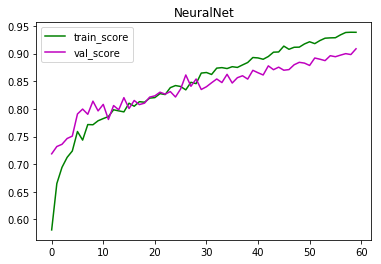

In [149]:
fh = hist.history
plt.title('NeuralNet')
plt.plot(fh['acc'], c='g', label='train_score')
plt.plot(fh['val_acc'], c='m', label='val_score')
plt.legend()
plt.savefig(f"./results/{FEATURE_AGGREGATION}/nn_{params_name}.png")

In [ ]:
pred_vss = model.predict(Xv_ss)[:,1]
pred_v = model.predict(Xv / sampler_nn.norm_val)[:,1]
pred_test = model.predict(Xts / sampler_nn.norm_val)[:,1]

In [ ]:
results['neural_net_RMSE_ss'] = RMSE(yv_ss[:,1], pred_vss)
results['neural_net_accuracy_ss'] = accuracy_score(yv_ss[:,1], pred_vss > 0.5)
results['neural_net_accuracy_test'] = accuracy_score(yv_ss[:,1], pred_vss > 0.5)

In [ ]:
results['neural_net_RMSE_full'] = RMSE(yv, pred_v)
results['neural_net_accuracy_full'] = accuracy_score(yv, pred_v > 0.5)

In [ ]:
pd.DataFrame(
    {k: [v] for k,v in results.items()}
).to_csv(f"./results/{FEATURE_AGGREGATION}/" + params_name + ".csv")